# Домашнее задание 1. Autoencoders & Frechet Inception Distance


В этом домашнем задании вам предлагается вспомнить то, что происходило на семинарах 1-2, написать свой автоэнкодер на CIFAR10 и использовать эмбеддинги от этого автоэнкодера чтобы посчитать Frechet Inception Distance (FID) между разными классами в CIFAR10

In [8]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from sklearn.ensemble import GradientBoostingClassifier
from collections import defaultdict
import seaborn as sns

Будем использовать torchvision для работы с данными.

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x * 2) - 1
])

In [10]:
train_dataset = datasets.CIFAR10(
    './cifar',
    train=True,
    transform=transform,
    download=True)
val_dataset = datasets.CIFAR10(
    './cifar',
    train=False,
    transform=transform,
    download=True)
len(train_dataset), len(val_dataset)

(50000, 10000)

Раз мы используем нормализацию картинок, то чтобы их нарисовать - надо их обратно разнормализировать

In [11]:
def denormalize_image(image):
    return (image + 1) / 2

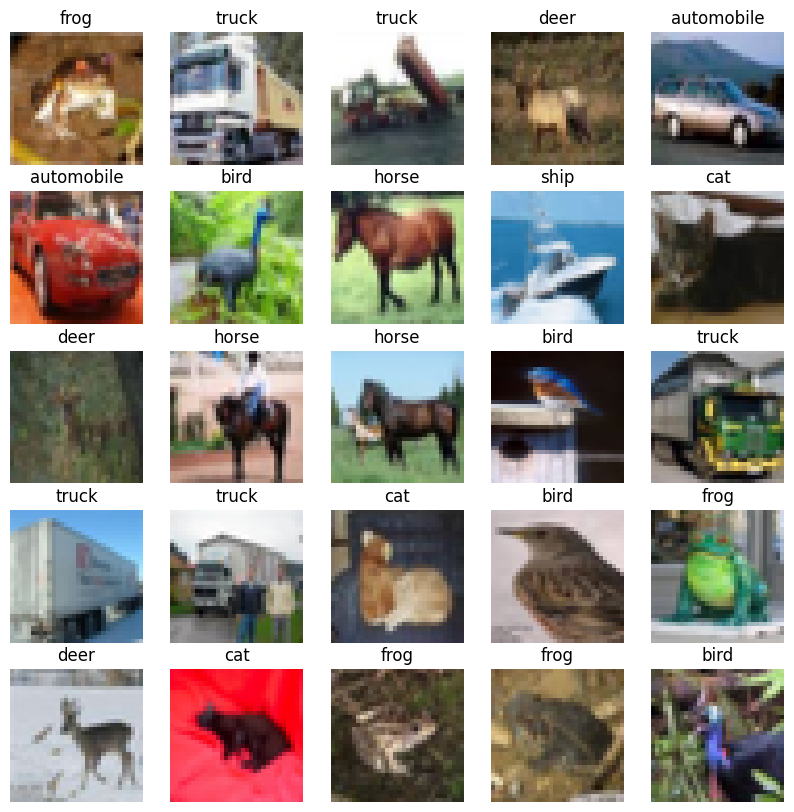

In [12]:
text_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 10))
for index, (image, label) in enumerate(train_dataset):
    plt.subplot(5, 5, index + 1)
    plt.imshow(denormalize_image(image.permute(1, 2, 0)))
    plt.axis('off')
    plt.title(text_labels[label])
    if index == 24: break
plt.show()

Размерность картинок: 3 канала 32х32 пикселя

In [13]:
image.shape

torch.Size([3, 32, 32])

In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
len(train_loader), len(val_loader)

(1563, 10000)

### Задание 1. Обучить AE (3 балла)

Постройте свой AE, можете использовать любые блоки которые вам кажутся необходимыми.

<img src='https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' width=500>

Напишите классы Encoder и Decoder

хинт: вам пригодятся nn.AvgPool2d/nn.MaxPool2d/Conv2d в энкодере и nn.Upsample/nn.ConvTranspose2d в декодере

In [15]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        ### BEGIN SOLUTION
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 16, 1),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        ### END SOLUTION
    def forward(self, x):
        ### BEGIN SOLUTION
        x = self.encoder(x)
        return x
        ### END SOLUTION

In [16]:
encoder = Encoder()
noise = torch.rand(1, 3, 32, 32) - 1
print(f"{encoder(noise).view(-1).shape=}")
assert encoder(noise).view(-1).shape[0] < 1*3*32*32

encoder(noise).view(-1).shape=torch.Size([256])


In [17]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        ### BEGIN SOLUTION
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1),
            nn.Tanh(),  # Normalize output between -1 and 1
        )
        ### END SOLUTION
    def forward(self, x):
        ### BEGIN SOLUTION
        x = self.decoder(x)
        return x
        ### END SOLUTION

In [18]:
decoder = Decoder()
noise = torch.rand(1, 3, 32, 32)
emb = encoder(noise)
print(f"{decoder(emb).shape=}")
assert decoder(emb).shape == (1, 3, 32, 32)

decoder(emb).shape=torch.Size([1, 3, 32, 32])


Посчитаем скор классификации картинок по эмбеддингам необученного энкодора, и в конце сравним с обученным. Для ускорения расчета, мы используем только часть трейна.

In [19]:
def classification_score(encoder, _train_dataset, val_dataset, device):
    encoder.eval()
    torch.manual_seed(0)
    train_dataset = Subset(_train_dataset, torch.randperm(len(_train_dataset))[:5000])
    X_train = []
    y_train = []
    for image, label in tqdm(train_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_train.append(emb.cpu().numpy().reshape(-1))
        y_train.append(label)
    X_train = np.stack(X_train)
    y_train = np.stack(y_train)
    clf = GradientBoostingClassifier(n_estimators=50, max_depth=5, verbose=1, random_state=0)
    clf.fit(X_train, y_train)
    X_val = []
    y_val = []
    for image, label in tqdm(val_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_val.append(emb.cpu().numpy().reshape(-1))
        y_val.append(label)
    X_val = np.stack(X_val)
    y_val = np.stack(y_val)
    return clf.score(X_val, y_val)

In [20]:
classification_score(Encoder(), train_dataset, val_dataset, 'cpu')

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.1404            4.44m
         2           2.0203            4.31m
         3           1.9136            4.37m
         4           1.8244            4.24m
         5           1.7443            4.12m
         6           1.6671            4.17m
         7           1.5996            4.04m
         8           1.5372            4.04m
         9           1.4811            4.04m
        10           1.4284            4.01m
        20           1.0465            3.30m
        30           0.8117            2.23m
        40           0.6658            1.10m
        50           0.5562            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

0.3344

In [21]:
device: str = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
device

'mps'

In [22]:
encoder.to(device)
decoder.to(device);

In [23]:
params = list(encoder.parameters()) + list(decoder.parameters())
optim = torch.optim.AdamW(params)

Напишите функцию train, которая обучает энкодер и декодер на всем трейн сете, возвращает среднюю MSE ошибку

In [24]:
def train(loader, optim, encoder, decoder, device):
    encoder.train()
    decoder.train()
    losses = []
    loss_fn = nn.MSELoss()
    for image, _ in tqdm(loader, leave=False):
        ### BEGIN SOLUTION
        image = image.to(device)

        optim.zero_grad()

        out = decoder(encoder(image))
        loss = loss_fn(out, image)
        loss.backward()
        optim.step()

        losses.append(loss.item())
        ### END SOLUTION
    return sum(losses) / len(losses)

In [25]:
loss = train(train_loader, optim, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

  0%|          | 0/1563 [00:00<?, ?it/s]

0.0245676998010886

Напишите функцию eval, которая возвращает среднюю MSE ошибку по всему валидационному сету

хинт: не забывайте отключать расчет градиентов

In [26]:
def eval(loader, encoder, decoder, device):
    encoder.eval()
    decoder.eval()
    losses = []
    loss_fn = nn.MSELoss()
    for image, _ in tqdm(loader, leave=False):
        ### BEGIN SOLUTION
        with torch.no_grad():
            image = image.to(device)
            out = decoder(encoder(image))
            losses.append(loss_fn(out, image).item())
        ### END SOLUTION
    return sum(losses) / len(losses)

In [27]:
loss = eval(val_loader, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

  0%|          | 0/10000 [00:00<?, ?it/s]

0.013199699845397844

Функция full_train возвращает обученный энкодер и декодер. Чтобы пройти ограничения по времени, обучите модель, а затем добавьте загрузку предобученных весов в самое начало функции. Можете использовать шаблон для загрузки весов из Google Drive.

In [28]:
from pathlib import Path
def full_train(device, train_loader, val_loader):
    encoder = Encoder().to(device)
    decoder = Decoder().to(device)

    ### BEGIN SOLUTION
    enc_weights_path = Path("weights/encoder_weights.pth")
    dec_weights_path = Path("weights/decoder_weights.pth")
    if enc_weights_path.exists() and dec_weights_path.exists():
        print(f"Loading weights from:\n{enc_weights_path=}\n{dec_weights_path=}")
        encoder.load_state_dict(torch.load(enc_weights_path, map_location=device))
        decoder.load_state_dict(torch.load(dec_weights_path, map_location=device))
        return encoder, decoder
    ### END SOLUTION

    params = list(encoder.parameters()) + list(decoder.parameters())
    optim = torch.optim.AdamW(params)
    train_loss = []
    val_loss = []
    n_epochs = 30
    for e in trange(n_epochs):
        e_train_loss = train(train_loader, optim, encoder, decoder, device)
        train_loss.append(e_train_loss)
        e_val_loss = eval(val_loader, encoder, decoder, device)
        val_loss.append(e_val_loss)
        print(f'Epoch: {e+1}/{n_epochs}')
        print(f'Train MSE loss: {e_train_loss:.4f}')
        print(f'Validation MSE loss: {e_val_loss:.4f}')
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.legend()
    plt.title('MSE Loss')
    plt.show()

    ### BEGIN SOLUTION
    torch.save(encoder.state_dict(), enc_weights_path)
    torch.save(decoder.state_dict(), dec_weights_path)
    ### END SOLUTION
    return encoder, decoder

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 1/30
Train MSE loss: 0.0263
Validation MSE loss: 0.0143


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 2/30
Train MSE loss: 0.0163
Validation MSE loss: 0.0127


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 3/30
Train MSE loss: 0.0149
Validation MSE loss: 0.0122


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 4/30
Train MSE loss: 0.0137
Validation MSE loss: 0.0115


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 5/30
Train MSE loss: 0.0131
Validation MSE loss: 0.0117


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 6/30
Train MSE loss: 0.0128
Validation MSE loss: 0.0111


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 7/30
Train MSE loss: 0.0124
Validation MSE loss: 0.0112


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 8/30
Train MSE loss: 0.0121
Validation MSE loss: 0.0108


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 9/30
Train MSE loss: 0.0120
Validation MSE loss: 0.0109


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 10/30
Train MSE loss: 0.0118
Validation MSE loss: 0.0107


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 11/30
Train MSE loss: 0.0117
Validation MSE loss: 0.0104


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 12/30
Train MSE loss: 0.0116
Validation MSE loss: 0.0105


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 13/30
Train MSE loss: 0.0115
Validation MSE loss: 0.0104


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 14/30
Train MSE loss: 0.0114
Validation MSE loss: 0.0106


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 15/30
Train MSE loss: 0.0113
Validation MSE loss: 0.0108


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 16/30
Train MSE loss: 0.0112
Validation MSE loss: 0.0104


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 17/30
Train MSE loss: 0.0112
Validation MSE loss: 0.0103


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 18/30
Train MSE loss: 0.0111
Validation MSE loss: 0.0103


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 19/30
Train MSE loss: 0.0111
Validation MSE loss: 0.0101


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 20/30
Train MSE loss: 0.0110
Validation MSE loss: 0.0105


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 21/30
Train MSE loss: 0.0109
Validation MSE loss: 0.0102


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 22/30
Train MSE loss: 0.0109
Validation MSE loss: 0.0102


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 23/30
Train MSE loss: 0.0108
Validation MSE loss: 0.0100


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 24/30
Train MSE loss: 0.0108
Validation MSE loss: 0.0103


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 25/30
Train MSE loss: 0.0108
Validation MSE loss: 0.0102


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 26/30
Train MSE loss: 0.0108
Validation MSE loss: 0.0100


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 27/30
Train MSE loss: 0.0107
Validation MSE loss: 0.0102


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 28/30
Train MSE loss: 0.0107
Validation MSE loss: 0.0100


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 29/30
Train MSE loss: 0.0107
Validation MSE loss: 0.0102


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 30/30
Train MSE loss: 0.0106
Validation MSE loss: 0.0102


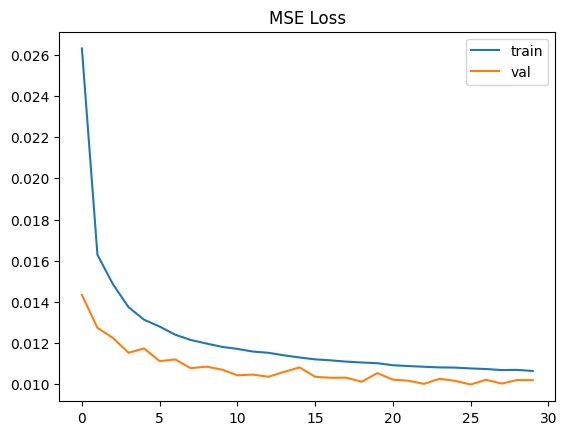

In [29]:
encoder, decoder = full_train(device, train_loader, val_loader)

In [30]:
score = classification_score(encoder, train_dataset, val_dataset, device)
assert score > 0.39
score

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.1315            3.91m
         2           2.0045            3.82m
         3           1.8900            3.74m
         4           1.7964            3.67m
         5           1.7133            3.58m
         6           1.6362            3.51m
         7           1.5706            3.45m
         8           1.5079            3.37m
         9           1.4483            3.29m
        10           1.3945            3.20m
        20           1.0017            2.39m
        30           0.7633            1.59m
        40           0.5995           48.09s
        50           0.4806            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

0.3976

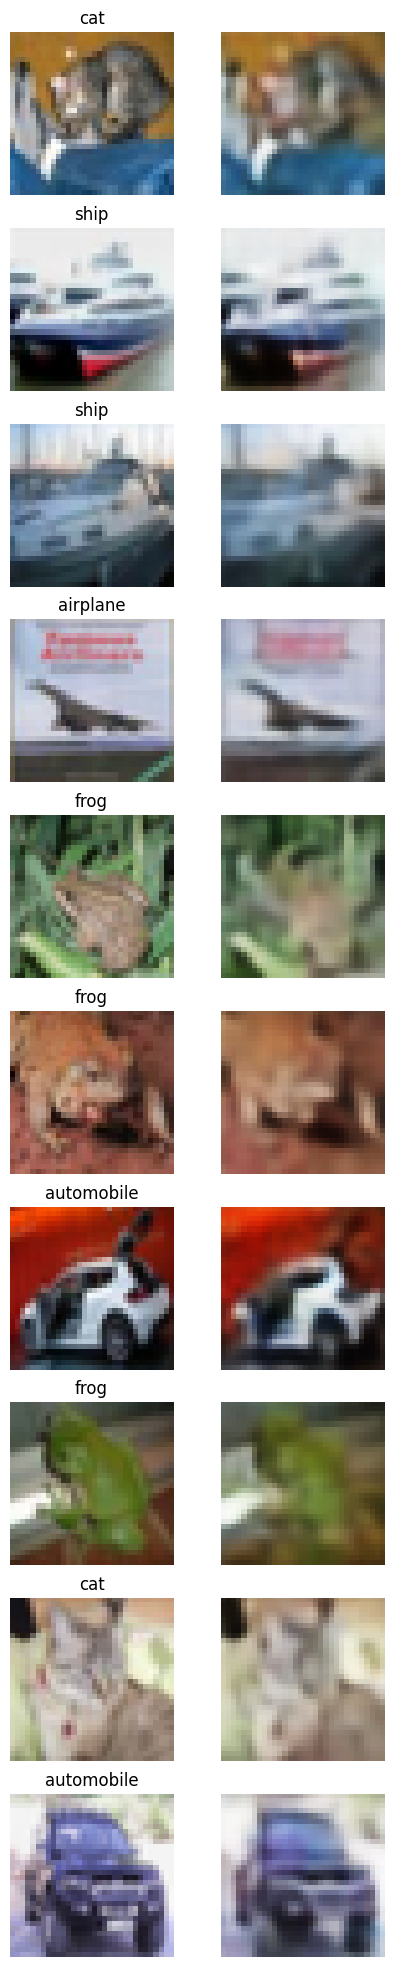

In [31]:
encoder.eval()
decoder.eval()
plt.figure(figsize=(5, 25))
for index, (image, label) in enumerate(val_loader):
    plt.subplot(10, 2, index*2+1)
    plt.imshow(denormalize_image(image)[0].permute(1, 2, 0))
    plt.axis('off')
    plt.title(text_labels[label])
    plt.subplot(10, 2, index*2+2)
    image = image.to(device)
    with torch.no_grad():
        emb = encoder(image)
        rec = decoder(emb).cpu()
    plt.imshow(denormalize_image(rec)[0].permute(1, 2, 0))
    plt.axis('off')
    if index == 9: break

### Задание 2. FID дистанция между классами CIFAR10 (3 балла)

В этой части хочется чтобы вы, используя bottleneck репрезентации от AE обученного в прошлой части посчитали FID дистанцию между различными классами CIFAR10 на **валидационной** выборке

За копию кода из сети будем снимать баллы

Напишите функцию get_representations, которая возвращает defaultdict, где ключ — это номер класса, значение — это список эмбеддингов, полученных из энкодера.

In [32]:
def get_representations(dataloader, encoder, device):
    representations = defaultdict(list)
    ### BEGIN SOLUTION
    for image, label in tqdm(dataloader):
        with torch.no_grad():
            image = image.to(device)
            representations[label.item()].append(encoder(image).view(-1))
    return representations
    ### END SOLUTION

In [33]:
representations = get_representations(val_loader, encoder, device)
assert len(representations) == 10
assert len(representations[0]) == 1000
assert type(representations[0][0]) == torch.Tensor
assert representations[0][0].shape == (256, )

  0%|          | 0/10000 [00:00<?, ?it/s]

Напишите функцию расчета FID
$$\text{FID}=\left\|\mu_{r}-\mu_{g}\right\|^{2}+T_{r}\left(\Sigma_{r}+\Sigma_{g}-2\left(\Sigma_{r} \Sigma_{g}\right)^{1 / 2}\right)$$

In [34]:
from scipy.linalg import sqrtm

def calculate_fid(repr1, repr2):
    ### BEGIN SOLUTION
    mu1, mu2 = np.mean(repr1, axis=0), np.mean(repr2, axis=0)
    diff = np.sum((mu1 - mu2) ** 2)

    sigma1, sigma2 = np.cov(repr1, rowvar=False), np.cov(repr2, rowvar=False)
    covmean = sqrtm(sigma1 @ sigma2)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid
    ### END SOLUTION

In [35]:
heatmap = np.zeros((10, 10))
for label_from in trange(10):
    for label_to in range(10):
        fid = calculate_fid(
            torch.stack(representations[label_from], dim=0).cpu().numpy(),
            torch.stack(representations[label_to], dim=0).cpu().numpy()
        )
        heatmap[label_from, label_to] = fid
assert heatmap.shape == (10, 10)
assert np.all(heatmap + 1e-5 > 0)
airplane_ship = heatmap[0, 8]
airplane_frog = heatmap[0, 6]
truck_automobile = heatmap[9, 1]
truck_dog = heatmap[9, 5]
assert airplane_ship < airplane_frog
assert truck_automobile < truck_dog

  0%|          | 0/10 [00:00<?, ?it/s]

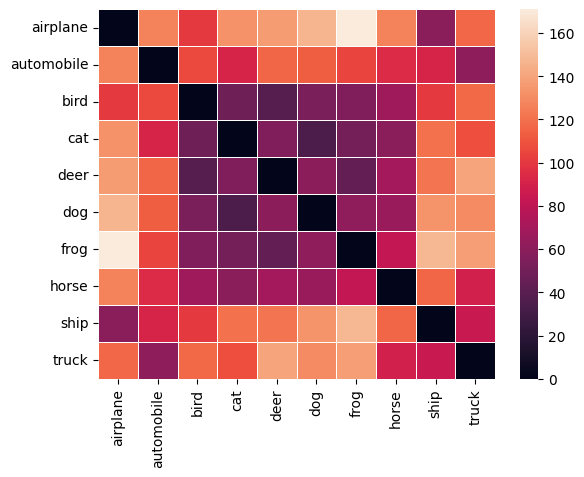

In [36]:
sns.heatmap(
    heatmap,
    linewidth=0.5,
    xticklabels=text_labels,
    yticklabels=text_labels
)
plt.show()

## Задание 3 (3 балла)

Выберите ваш любимый датасет с кошками и собаками и посчитайте FID между двумя классами на новых данных, используя репрезентацию с уже обученного AE

хинт: если любимого датасета с кошками и собаками нет, можно вырезать эти классы из имажнета

хинт: если вам оооочень не нравятся кошки и собаки, то можете выбрать другие два противоположных класса

Link to dataset: https://www.kaggle.com/datasets/marquis03/cats-and-dogs

In [37]:
import kagglehub
from pathlib import Path
dataset_path = Path(kagglehub.dataset_download("marquis03/cats-and-dogs"))
dataset_path

PosixPath('/Users/mgorodov/.cache/kagglehub/datasets/marquis03/cats-and-dogs/versions/2')

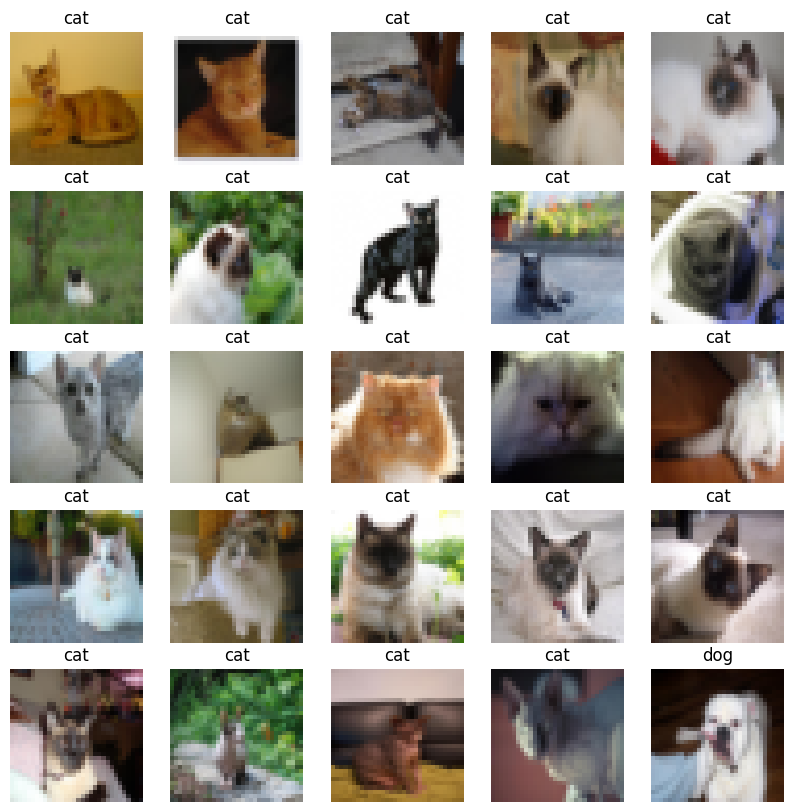

In [38]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    lambda x: (x * 2) - 1
])

#train_catdogs_dataset = ImageFolder(root=dataset_path / 'train', transform=transform)
val_catdogs_dataset = ImageFolder(root=dataset_path / 'val', transform=transform)
text_labels = ['cat', 'dog']
plt.figure(figsize=(10, 10))
for index, (image, label) in enumerate(val_catdogs_dataset):
    plt.subplot(5, 5, index + 1)
    plt.imshow(denormalize_image(image).permute(1, 2, 0))
    plt.axis('off')
    plt.title(text_labels[label])
    if index == 24: break
plt.show()

In [39]:
#train_catdogs_loader = DataLoader(train_catdogs_dataset, batch_size=32, shuffle=True)
val_catdogs_loader = DataLoader(val_catdogs_dataset, batch_size=1, shuffle=False)

In [40]:
representations = get_representations(val_catdogs_loader, encoder, device)
assert len(representations) == 2
assert type(representations[0][0]) == torch.Tensor
assert representations[0][0].shape == (256, )

  0%|          | 0/70 [00:00<?, ?it/s]

In [41]:
heatmap = np.zeros((2, 2))
for label_from in trange(2):
    for label_to in range(2):
        fid = calculate_fid(
            torch.stack(representations[label_from], dim=0).cpu().numpy(),
            torch.stack(representations[label_to], dim=0).cpu().numpy()
        )
        heatmap[label_from, label_to] = fid
assert heatmap.shape == (2, 2)
assert np.all(heatmap + 1e-4 > 0)

  0%|          | 0/2 [00:00<?, ?it/s]

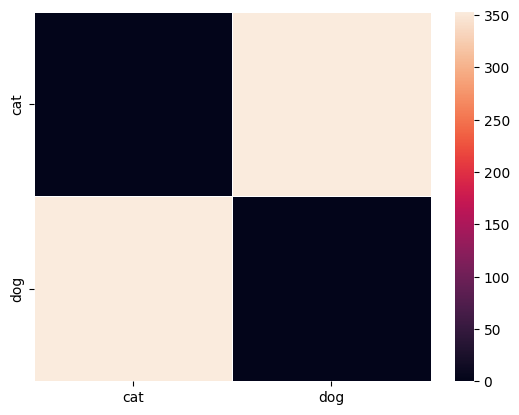

In [42]:
sns.heatmap(
    heatmap,
    linewidth=0.5,
    xticklabels=text_labels,
    yticklabels=text_labels
)
plt.show()

In [43]:
print(f'fid: {heatmap[0][1]}')

fid: 353.2617423279253


## Задание 4 (1 балл)

Вы отлично поработали и, скорее всего, в процессе выполнения этих задач у вас появились идеи о том, как еще можно решать подобные проблемы. 

Здесь вы можете описать способы которые вам хотелось бы попробовать если бы у вас было больше времени, или показать статьи которые вы читали, которые решают такие задачи.

Дополнительно, необходимо приложить сюда какой-нибудь смешной мем про генеративные модели за последние два года. Если мем будет не смешным, то баллы придется снять.


- Хотелось бы научиться решать такие задачи в realtime, брать данные из видеопотока например
- Поэкспериментировать с кодировками, цветовыми схемами и диапазонами
- Попробовать другие типы энкодеров и посмотреть на разные метрики для оценки качества.


<img src="meme.jpg" alt="alt text" width="600"/>